## Setup

In [ ]:
!nvidia-smi

Mon Jun 27 14:49:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt # for plotting
import seaborn as sns
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.autograd import Variable 

#!pip install pandas==1.3.0 #1.3.0
import pandas as pd

import glob
!pip3 install pickle5
import pickle5 as pickle
import os

from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm
#from pandas.core.computation.check import NUMEXPR_INSTALLED

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 4.1 MB/s 


### Five Key Steps
#### 1. Load and normalize the train and test data 
#### 2.Define the Convolutional Neural Network (CNN)
#### 3. Define the loss function and optimizer
#### 4. Train the model on the train data
#### 5. Test the model on the test data

In [ ]:
#Mount Drive to get data
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#set the device to cuda:0 
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  

## Dataset

In [ ]:
#Load In the Dataset
class EEGDataset(Dataset):

  def __init__(self, data_path, chunk_size=1000):
    """
        Args:
            data_path (string): Directory with the EEG training data. Filenames in this dir must begin with "PD" or "Control" to assign labels correctly. Must be in .csv files. 
            chunk_size (int): Number of datapoints from EEG time series to be included in a single non-overlapping epoch. Note that UNM data was collected at 500Hz.
    """
    
    #create a list of datafields to keep. The electrodes given here are those in common to both the UI and UNM datasets.
    self.common_electrodes = ['time', 'Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'POz', 'PO8', 'P6', 'P2', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']

    #create the datapaths
    self.data_path = data_path  
    self.data_list = glob.glob(self.data_path + "*.csv")

    #create containers for the data and labels respectively
    self.df_list = []
    self.label_list = []

    self.files = glob.glob(self.data_path+ '*.csv')

    for file in self.files:

      if os.path.isfile(file):
        csv = pd.read_csv(file,sep=',', index_col=[0]) #load in single session as a csv
        csv = csv.drop(index=0, inplace=False, axis=0) #drop first row (timepoint) because can contain noise
        csv = csv[self.common_electrodes]              #select the subset of electrodes defined by self.common_electrodes
        csv = csv.drop('time', inplace=False, axis=1)  #drop time so it is not considered as a variable

        #csv is then segmented into epochs. Each epochs is added as a df to the list of data with a corresponding list of labels (at this point the whole filename is given as the label).
        for chunk in range(1,csv.shape[0]//chunk_size +1):
            start = (chunk-1)*chunk_size
            stop = chunk*chunk_size
            self.df_list.append(csv.iloc[start:stop])
            self.label_list.append(file)

    print('there are this many items in the list of data ' ,len(self.df_list))  
    print('there are this many items in the list of labels ' , len(self.label_list))

    #define the labels as vectors so that cross-entropy loss can be used
    self.class_map = {"CTL" : [0, 1], "PD": [1, 0]} 
    
    #Normalize each channel of each epoch to a mean of 0 and std of 1.
    self.all_data = self.df_list[0]
    
    self.normalized_df_list = []
    
    #iterate through each epoch
    for df_index in range(0,len(self.df_list)):
      
      temp_df = self.df_list[df_index]
      mean_by_channel = []
      std_by_channel = []
      
      #determine normalization parameters by column (i.e. for each channel)
      for column in temp_df:
        mean_by_channel.append(temp_df[column].mean())
        std_by_channel.append(temp_df[column].std())

      #apply normalization
      temp_df = temp_df.sub(mean_by_channel, axis='columns')
      temp_df = temp_df.div(std_by_channel, axis='columns')
      self.normalized_df_list.append(temp_df)

    assert (len(std_by_channel)== len(mean_by_channel)), 'length of mean normalization and std normalization are not same length'
    print('The length of the lists of channels means and stds is ', len(mean_by_channel))
    assert ((self.normalized_df_list[0].shape)==(self.df_list[0].shape) and (len(self.normalized_df_list)==len(self.df_list))), 'Normalization changed the shape of the df_list'
      

  #this is a required function that tells you how many data points you have in the dataset
  def __len__(self):
      return len(self.normalized_df_list) 

  #this is a required function that allows you to obtain a single data point according to its index
  def __getitem__(self, idx):
    
    #each dataframe represents one epoch. idx selects a random one.
    eeg_dataframe = self.normalized_df_list[idx]
    
    #determine whether that subject is control or PD
    filename = self.label_list[idx].split('/')[-1]

    #this is the string containing the filename. index first 2 chars to see if PD.
    if filename[0:2]=='PD':        
      PD_label = 'PD'
    #then see if its control
    elif filename[0:7]=='Control': 
      PD_label = 'CTL'
    #if neither, throw an error
    else:                           
      print(self.label_list[idx][0:2])
      print(self.label_list[idx][0:7])
      assert False, 'there is a problem finding the label'

    #convert label to tensor using class map
    PD_label = torch.tensor(self.class_map[PD_label], dtype=torch.long)
   
    #reformat the eeg data
    eeg_tensor = torch.tensor(eeg_dataframe[0:chunk_size].values) #you can artificially shorten epochs here
    eeg_tensor = torch.permute(eeg_tensor,(1, 0))
    
    
    return eeg_tensor.float(), PD_label.float()


## Define the Neural Network

In [ ]:
class PDNet(nn.Module):

    def __init__(self,chunk_size=2500):
        super(PDNet, self).__init__()
        self.chunk_size = chunk_size

        self.conv1 = nn.Conv1d(in_channels=60, out_channels=21, kernel_size=20,stride=1)
        self.norm1 = nn.BatchNorm1d(num_features=21)
        self.maxpool1 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv2 = nn.Conv1d(in_channels=21, out_channels=42, kernel_size=10,stride=1)
        self.norm2 = nn.BatchNorm1d(num_features=42)
        self.maxpool2 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv3 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=10,stride=1)
        self.norm3 = nn.BatchNorm1d(num_features=42)
        self.maxpool3 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv4 = nn.Conv1d(in_channels=42, out_channels=64, kernel_size=5,stride=1)
        self.norm4 = nn.BatchNorm1d(num_features=64)
        self.maxpool4 = nn.MaxPool1d(kernel_size=4,stride=4)

        
        self.relu = nn.LeakyReLU(0.1)

        
        self.fc1 = nn.Linear(in_features=448,out_features=256)#in_features=4*(self.chunk_size-8)
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(in_features=64, out_features=16)
        self.fc4 = nn.Linear(in_features=16, out_features=2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = self.relu(self.maxpool1(self.norm1(self.conv1(x))))

        x = self.relu(self.maxpool2(self.norm2(self.conv2(x))))
        
        x = self.relu(self.maxpool3(self.norm3(self.conv3(x))))
        
        x = self.relu(self.maxpool4(self.norm4(self.conv4(x))))
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        
        x = self.dropout1(self.fc1(x))
        x = self.dropout2(self.fc2(x))
        x = self.fc3(x)

        x = self.softmax(self.fc4(x))
        return x


In [ ]:
#test the input and output shapes
input_tensor = torch.rand([8,60,2500]).cuda() #of the form [batch_size, channels, epoch_length]
print(input_tensor.size())
network = PDNet().cuda()
output_tensor = network(input_tensor)
print((output_tensor.shape))


torch.Size([8, 60, 2500])
torch.Size([8, 2])


## Train and Validate Methods

In [ ]:
def train(model,train_dataloader, val_dataloader, epochs=30, learning_rate=0.0001, training_loss_tracker=[], val_loss_tracker=[]):
    '''
    INPUTS:
      model(nn.Module): here we will pass PDNet to the training loop.
      train_dataloader(Dataloader): here we will pass the torch.utils.dataloader.Dataloader containing all the training batches. 
      val_dataloader(Dataloader): here we will pass the torch.utils.dataloader.Dataloader containing all the validation batches. 
      epochs(int): the total number of epochs to train for
      learning_rate(float): training hyperparameter defines the rate at which the optimizer will learn
      training_loss_tracker(list): list containing float values of training loss from previous training. The length of this list
      will be taken as the current epoch number.
      val_loss_tracker(list):list containing float values of validation loss from previous training. 
    
    OUTPUTS:
      model(nn.Module): updated network after being trained.
      training_loss_tracker(list): updated list containing float values of training loss from previous training. 
      val_loss_tracker(list): updated list containing float values of validation loss from previous training. 
    '''
    assert epochs > len(training_loss_tracker), 'Loss tracker is already equal to or greater than epochs'

    #define loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.5,0.5]).cuda()) #you can adjust weights. first number is applied to PD and the second number to Control
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #start a timer
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    current_epoch = len(training_loss_tracker)
    counter = 0

    #here, we take Epoch in a deep learning sense (i.e. iteration of training over the whole dataset)
    for epoch in range(current_epoch, epochs): 
        
        running_loss = 0.0
        counter = 0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = torch.permute(inputs,(0,1,2)).to(device), labels.to(torch.float32).to(device) #send them to the GPU
            
            batch_size = inputs.shape[0]
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward 
            outputs = model(inputs)

            #Apply L2 Regularization. Replace pow(2.0) with abs() for L1 regularization
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                  
            #loss + backward + optimize
            loss = criterion(outputs,labels) + l2_lambda*l2_norm
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            counter += 1
          
        # perform validation every N epochs (adjust val_every)
        val_every = 1
        if epoch % val_every == 0:    
          print('[epoch: %d, batch: %5d] average training loss: %.3f' % (epoch + 1, i + 1, running_loss / counter ))
          training_loss_tracker.append(running_loss/counter)
          running_loss = 0.0
          counter = 0
          current_val_loss = 0
          current_val_loss = validate(model,val_dataloader,batch_size=batch_size)
          val_loss_tracker.append(current_val_loss)

    # whatever you are timing goes here
    end.record()

    # Waits for everything to finish running
    torch.cuda.synchronize()

    print('Finished Training Session')
    print('Time elapsed in miliseconds: ', start.elapsed_time(end))  # milliseconds
    print('The training loss at the end of this session is: ',loss.item())

    return model, training_loss_tracker, val_loss_tracker


In [ ]:
#testing the performance
def validate(model, valloader,threshold=0.5,batch_size=8):
  '''
    INPUTS:
      model(nn.Module): here we will pass PDNet to the training loop. 
      valloader(Dataloader): here we will pass the torch.utils.dataloader.Dataloader containing all the validation batches. 
      threshold(float): give a threshold above which a classification will be binarized to PD and below to CTL
      batch_size(int): batch size of the valloader
    
    OUTPUTS:
      avg_loss(float): for validation tracking purposes
  '''
  total_loss = 0
  true_positives = 0
  true_negatives = 0
  false_positives = 0
  false_negatives = 0

  counter = 0

  #This loads a batch at time
  for i, data in enumerate(valloader, 0):
    #read in data
    inputs, labels = data
    inputs, labels = torch.permute(inputs,(0,1,2)).to(device), labels.to(torch.float32).to(device) #send them to the GPU
    
    #forward
    output = model(inputs)

    #calculate loss for tracking purposes. Ensure regularization matches that in the training loop.
    criterion = nn.CrossEntropyLoss() 
    l2_lambda = 0.0001
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    total_loss += criterion(output,labels) + l2_lambda*l2_norm 
    counter += 1

    #binarize output according to the threshold you set
    output[output>threshold] = 1
    output[output<=threshold] = 0
    
    #determine whether each classification was true/false and postive/negative
    for j in range(0,len(output)):
      if (output[j-1,0] == 1) and (labels[j-1,0] == 1):
          true_positives += 1
      elif(output[j-1,0]==1) and (labels[j-1,0] == 0 ):
          false_positives += 1
      elif(output[j-1,0]==0) and (labels[j-1,0]== 1):
          false_negatives += 1
      elif(output[j-1,0]==0) and (labels[j-1,0]== 0):
          true_negatives += 1
  
  print('true positives: ', true_positives)
  print('false positives: ',false_positives)
  print('true negatives: ',true_negatives)
  print('false negatives', false_negatives)    
  avg_loss = total_loss/counter 
  print("the average validation loss value is: ", avg_loss.item())
  print('--------------------------------------------------')

  return avg_loss.item()

## Main Method/Call Training Loop

In [ ]:
################ CREATE DATASET  ############################################
batch_size = 8
num_workers = 2
chunk_size = 2500

#set data location to directory with training data. 
data_src = '/content/drive/MyDrive/UNM_Data/' #full

#load in the EEG to the dataset class
EEG_Dataset = EEGDataset(data_path=data_src, chunk_size=chunk_size)


there are this many items in the list of data  2122
there are this many items in the list of labels  2122
The length of the lists of channels means and stds is  60


### Run single experiment

In [ ]:
################ CREATE DATALOADER  ############################################
#define the train test split
train_size = int(0.90 * len(EEG_Dataset))
val_size = len(EEG_Dataset) - train_size
train_dataset, val_dataset = random_split(EEG_Dataset, [train_size, val_size],generator=torch.Generator().manual_seed(401))

#create a respective dataloader out of the test/train split
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True, num_workers=num_workers)

print(next(iter(trainloader))[0].size())
print('there are this many batches in the training dataloader:',len(trainloader))
print(next(iter(valloader))[0].size())
print('there are this many batches in the validation dataloader: ',len(valloader))
#the trainlaoder has 91 batches, the valloader has 16 batches

torch.Size([8, 60, 2500])
there are this many batches in the training dataloader: 239
torch.Size([8, 60, 2500])
there are this many batches in the validation dataloader:  27


In [ ]:
############# choose name for model--Load or create model ######################
experiment_name = 'UNM_training_demo' 
model_folder = '/content/drive/MyDrive/'
PATH = model_folder + experiment_name 

if (os.path.exists(PATH )):
  model = torch.load(PATH).to(device)
  print(' model has been successfully loaded')
  
else:
  model = PDNet(chunk_size=chunk_size).to(device)
  log_containing_train_loss = []
  log_containing_val_loss = []
  print(' model has been successfully created')

 model has been successfully created


In [ ]:
#run training

print('Please note that the train-test split was created without regard for which epochs belong to which subject. Therefore, there is information leakage between training and validation \n use these numbers as a guide for training but not as an estimate for test performance.')

model.train()
model, log_containing_train_loss, log_containing_val_loss = train(model=model,train_dataloader=trainloader, val_dataloader=valloader, epochs=3, learning_rate=0.0001, training_loss_tracker=[], val_loss_tracker=[])

Please note that the train-test split was created without regard for which epochs belong to which subject. Therefore, there is information leakage between training and validation 
 use these numbers as a guide for training but not as an estimate for test performance.
[epoch: 1, batch:   239] average training loss: 0.668
true positives:  80
false positives:  31
true negatives:  70
false negatives 32
the average validation loss value is:  0.6518601775169373
--------------------------------------------------
[epoch: 2, batch:   239] average training loss: 0.598
true positives:  90
false positives:  14
true negatives:  87
false negatives 22
the average validation loss value is:  0.52630215883255
--------------------------------------------------
[epoch: 3, batch:   239] average training loss: 0.546
true positives:  98
false positives:  16
true negatives:  85
false negatives 14
the average validation loss value is:  0.46952491998672485
--------------------------------------------------
Fini

In [ ]:
############## UNCOMMENT TO SAVE MODEL-- BEWARE OVERWRITING ##############
#torch.save(model, PATH)

torch.utils.data.dataloader.DataLoader

### Run replicates

In [ ]:
# This ccell can be used to train a set of replicates they will all be saved to this model folder
model_folder = '/content/drive/MyDrive/UTOR-MSc/colab_notebooks/model_weights/'
replicates = 3

for i in range(replicates):
  #define the train test split
  train_size = int(0.90 * len(EEG_Dataset))
  val_size = len(EEG_Dataset) - train_size
  train_dataset, val_dataset = random_split(EEG_Dataset, [train_size, val_size],generator=torch.Generator().manual_seed(i))

  #create a respective dataloader out of the test/train split
  trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  valloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True, num_workers=num_workers)
  ####################### CREATE OR LOAD MODEL ############################3
  experiment_name = 'UNM_training_replicates_demo_' + str(i) 
  PATH = model_folder + experiment_name
  if (os.path.exists(PATH)):
    model = torch.load(PATH).to(device)
    print(' model has been successfully loaded')
  else:
    model = PDNet(chunk_size=chunk_size).to(device)
    log_containing_train_loss = []
    log_containing_val_loss = []
    print('model ', i, ' has been successfully created')
  ##################################################################33
  model.train()
  model = log_containing_train_loss, log_containing_val_loss = train(model=model,train_dataloader=trainloader, val_dataloader=valloader, epochs=30, learning_rate=0.0001, training_loss_tracker=[], val_loss_tracker=[])  

  ##############################################################
  torch.save(model, PATH)

model  0  has been successfully created
[epoch: 1, batch:   239] average training loss: 0.668
true positives:  99
false positives:  44
true negatives:  50
false negatives 20
the average validation loss value is:  0.6467496156692505
--------------------------------------------------
[epoch: 2, batch:   239] average training loss: 0.611
true positives:  82
false positives:  14
true negatives:  80
false negatives 37
the average validation loss value is:  0.5735492706298828
--------------------------------------------------


KeyboardInterrupt: ignored

## Evaluation

In [ ]:
#run validation
model.eval()

#validate using a single threshold
#validate(model=model,valloader=valloader,threshold=0.5,batch_size=batch_size)

#validate using a list of thresholds
for threshold in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
  print('Validating using threshold = ', threshold)
  validate(model=model,valloader=valloader,threshold=threshold,batch_size=batch_size)


Validating using threshold =  0
true positives:  112
false positives:  101
true negatives:  0
false negatives 0
the average validation loss value is:  0.44812989234924316
--------------------------------------------------
Validating using threshold =  0.1
true positives:  109
false positives:  27
true negatives:  74
false negatives 3
the average validation loss value is:  0.4478416442871094
--------------------------------------------------
Validating using threshold =  0.2
true positives:  106
false positives:  19
true negatives:  82
false negatives 6
the average validation loss value is:  0.4510749280452728
--------------------------------------------------
Validating using threshold =  0.3
true positives:  102
false positives:  13
true negatives:  88
false negatives 10
the average validation loss value is:  0.4483664035797119
--------------------------------------------------
Validating using threshold =  0.4
true positives:  99
false positives:  10
true negatives:  91
false negativ

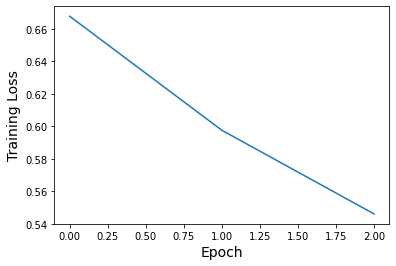

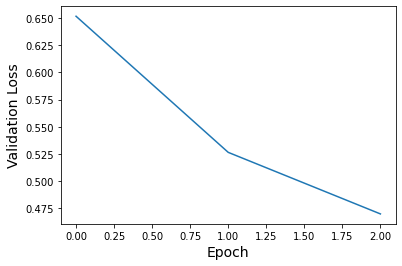

In [ ]:
#Print Learning Curves
training_loss = sns.lineplot(x = np.arange(0,len(log_containing_train_loss)), y = log_containing_train_loss) 
_ = training_loss.set_xlabel('Epoch',size=14)
_ = training_loss.set_ylabel('Training Loss',size=14)
plt.show()
validation_loss = sns.lineplot(x = np.arange(0,len(log_containing_val_loss)), y = log_containing_val_loss) 
_ = validation_loss.set_xlabel('Epoch',size=14)
_ = validation_loss.set_ylabel('Validation Loss',size=14)
plt.show()